In [1]:
from investesg import InvestESG
import numpy as np

Create Schelling diagram in this notebook.

In [26]:
env = InvestESG(company_attributes=[{'capital':12,'climate_risk_exposure':0.07,'beta':0},
                                    {'capital':12,'climate_risk_exposure':0.07,'beta':0},
                                    {'capital':12,'climate_risk_exposure':0.07,'beta':0},
                                    {'capital':12,'climate_risk_exposure':0.07,'beta':0},
                                    {'capital':12,'climate_risk_exposure':0.07,'beta':0}],
                investor_attributes=[{'capital':0,'esg_preference':0},
                                     {'capital':0,'esg_preference':0},
                                     {'capital':0,'esg_preference':0}], 
                                    initial_climate_event_probability=0.5,
                                    market_performance_baseline=1.1, market_performance_variance=0, allow_resilience_investment=True)

In [49]:
def manual_test_case(focal_company_action, cooperator_action, defector_action, num_other_company_cooperators, output_fig=False):
    env.reset()
    for i in range(100):
        # Company actions: company 0 is the focal company
        company_actions = {f"company_{i}": env.action_space(f"company_{i}").sample() for i in range(env.num_companies)}
        company_actions['company_0'] = np.array(focal_company_action)
        # set actions for cooperator companies
        for i in range(1, num_other_company_cooperators + 1):
            company_actions[f'company_{i}'] = np.array(cooperator_action)
        # set actions for defector companies
        for i in range(num_other_company_cooperators + 1, env.num_companies):
            company_actions[f'company_{i}'] = np.array(defector_action)

        # Investor actions: continuous values that sum to 1
        investor_actions = {f"investor_{i}": env.action_space(f"investor_{i}").sample() for i in range(env.num_investors)}

        # Set specific investor actions
        focal_cooperator = np.array_equal(focal_company_action, cooperator_action)
        num_cooperators = num_other_company_cooperators + focal_cooperator

        # get unique esg scores of companies
        esg_scores = [env.companies[i].esg_score for i in range(env.num_companies)]
        # get the highest esg score; investors with high esg preference will invest in these companies
        highest_esg_score = max(esg_scores)

        # investors who prefer ESG invest in cooperators, otherwise in defectors
        for i in range(env.num_investors):
            if env.investors[i].esg_preference > 0.5:
                # invest 1 in companies with highest esg score
                investor_actions[f'investor_{i}'] = [1 if env.companies[j].esg_score == highest_esg_score else 0 for j in range(env.num_companies)]

                # # invest 1 in cooperator companies
                # investor_actions[f'investor_{i}'] = [1 if ((j > 0 and j <= num_other_company_cooperators) or 
                #                                       (j == 0 and focal_cooperator)) 
                #                                  else 0 for j in range(env.num_companies)]
                # # if no cooperator, invest in all companies
                # if num_cooperators == 0:
                #     investor_actions[f'investor_{i}'] = [1 for j in range(env.num_companies)]
            else:
                # invest 1 in low esg score companies
                investor_actions[f'investor_{i}'] = [1 if env.companies[j].esg_score < highest_esg_score else 0 for j in range(env.num_companies)]
                # if all companies have the same esg score, invest in all companies
                if len(set(esg_scores)) == 1:
                    investor_actions[f'investor_{i}'] = [1 for j in range(env.num_companies)]
                # # invest 1 in defector companies
                # investor_actions[f'investor_{i}'] = [0 if ((j > 0 and j <= num_other_company_cooperators) or 
                #                                       (j == 0 and focal_cooperator)) 
                #                                  else 1 for j in range(env.num_companies)]
                # # if everyone cooperator, invest in all companies
                # if num_cooperators == env.num_companies:
                #     investor_actions[f'investor_{i}'] = [1 for j in range(env.num_companies)]

        actions = {**company_actions, **investor_actions}
        obs, rewards, terminations, truncations, infos = env.step(actions)
    
    focal_company_payoff = env.history['company_capitals'][0][-1]
    if num_other_company_cooperators > 0:
        cooperator_payoff = env.history['company_capitals'][1][-1]
    else:
        cooperator_payoff = 0
    if num_other_company_cooperators + 1 < env.num_companies:
        defector_payoff = env.history['company_capitals'][num_other_company_cooperators + 1][-1]
    else:
        defector_payoff = 0
    # average payoff is the weighted average of the defactor company and the cooperator
    average_payoff = (focal_company_payoff + cooperator_payoff*num_other_company_cooperators + defector_payoff*(env.num_companies - num_other_company_cooperators - 1))/env.num_companies

    if output_fig:
        env.render()
        display(env.fig)

        print(f"Company 0: {focal_company_payoff}")
        if num_other_company_cooperators > 0:
            print(f"Company cooperator: {cooperator_payoff}")
        if num_other_company_cooperators + 1 < env.num_companies:
            print(f"Company Defector: {defector_payoff}")
        # average company ending capital
        print(f"Average company ending capital: {average_payoff}")

    else:
        return focal_company_payoff, cooperator_payoff, defector_payoff, average_payoff


In [24]:
import matplotlib.pyplot as plt
def run_schelling_diagram(cooperator_action, defector_action, return_results=False):
    cooperator_payoff_ls = []
    defector_payoff_ls = []
    average_payoff_ls_w_defector = []
    average_payoff_ls_w_cooperator = []

    # defector
    focal_company_action = defector_action
    for i in range(5):
        focal_company_payoff, cooperator_payoff, defector_payoff, average_payoff = manual_test_case(focal_company_action, cooperator_action, defector_action, i)
        defector_payoff_ls.append(focal_company_payoff)
        average_payoff_ls_w_defector.append(average_payoff)

    # cooperator
    focal_company_action = cooperator_action
    for i in range(5):
        focal_company_payoff, cooperator_payoff, defector_payoff, average_payoff = manual_test_case(focal_company_action, cooperator_action, defector_action, i)
        cooperator_payoff_ls.append(focal_company_payoff)
        average_payoff_ls_w_cooperator.append(average_payoff)

    # Get colors from the rainbow colormap
    colors = plt.cm.rainbow([0.15, 0.7, 0.99])  # This gives us a red, green, and blue from the rainbow spectrum

    plt.plot(defector_payoff_ls, label='Defector Payoff', color=colors[2])
    plt.plot(average_payoff_ls_w_defector, label='Average Payoff with Defector', color=colors[1], linestyle='--', marker='x')
    plt.plot(cooperator_payoff_ls, label='Cooperator Payoff', color=colors[0])
    # plt.plot(average_payoff_ls_w_cooperator, label='Average Payoff with Cooperator', color=colors[1], linestyle='--', marker='o')
    # make x axis integer
    plt.xticks(range(len(defector_payoff_ls)), range(len(defector_payoff_ls)))
    plt.xlabel('Number of Other Agents Cooperating Out of 4')
    plt.ylabel('Individual Ending Capital')
    plt.legend()
    plt.show()

    if return_results:
        return defector_payoff_ls, cooperator_payoff_ls, average_payoff_ls_w_defector, average_payoff_ls_w_cooperator

# Plots

## Companies: mitigation only

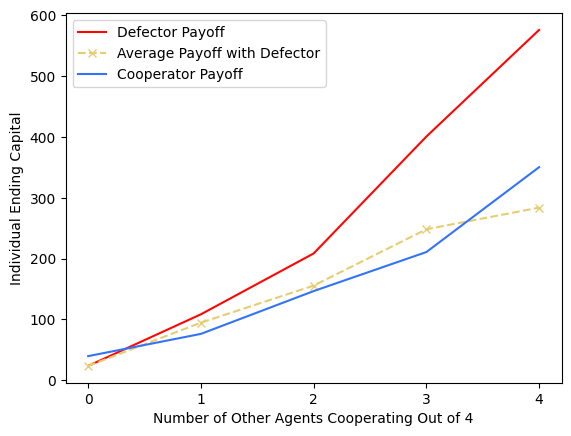

In [27]:
cooperator_action = [0.01,0,0]
defector_action = [0,0,0]

run_schelling_diagram(cooperator_action, defector_action)

## Companies: mitigation & resilience


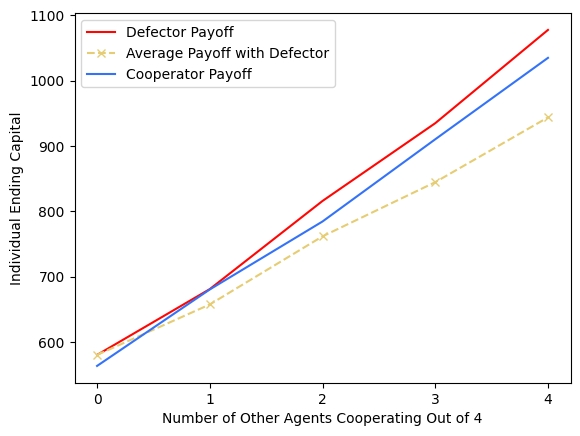

In [28]:
cooperator_action = [0.001,0,0.009]
defector_action = [0,0,0.01]
run_schelling_diagram(cooperator_action, defector_action)

## Investors

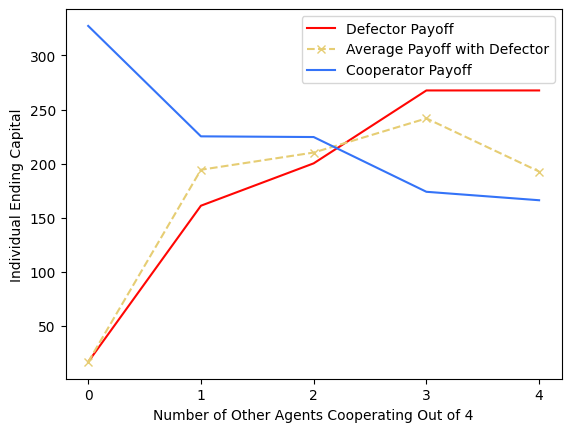

In [29]:
env = InvestESG(
    company_attributes=[{'capital': 6, 'climate_risk_exposure': 0.07, 'beta': 0}] * 5,
    investor_attributes=[{'capital': 6, 'esg_preference': 5}] * 5,
    initial_climate_event_probability=0.5,
    market_performance_baseline=1.1,
    market_performance_variance=0,
    allow_resilience_investment=True
)

cooperator_action = [0.01,0,0]
defector_action = [0,0,0]
run_schelling_diagram(cooperator_action, defector_action)

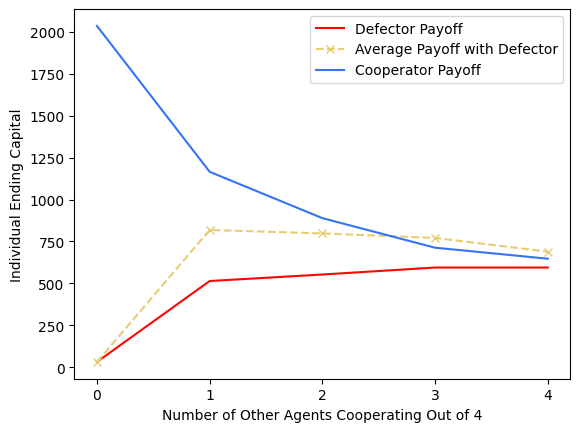

In [30]:
env = InvestESG(
    company_attributes=[{'capital': 6, 'climate_risk_exposure': 0.07, 'beta': 0}] * 5,
    investor_attributes=[{'capital': 20, 'esg_preference': 0.5}] * 3,
    initial_climate_event_probability=0.5,
    market_performance_baseline=1.1,
    market_performance_variance=0,
    allow_resilience_investment=True
)

cooperator_action = [0.01,0,0]
defector_action = [0,0,0]
run_schelling_diagram(cooperator_action, defector_action)

<Figure size 640x480 with 0 Axes>

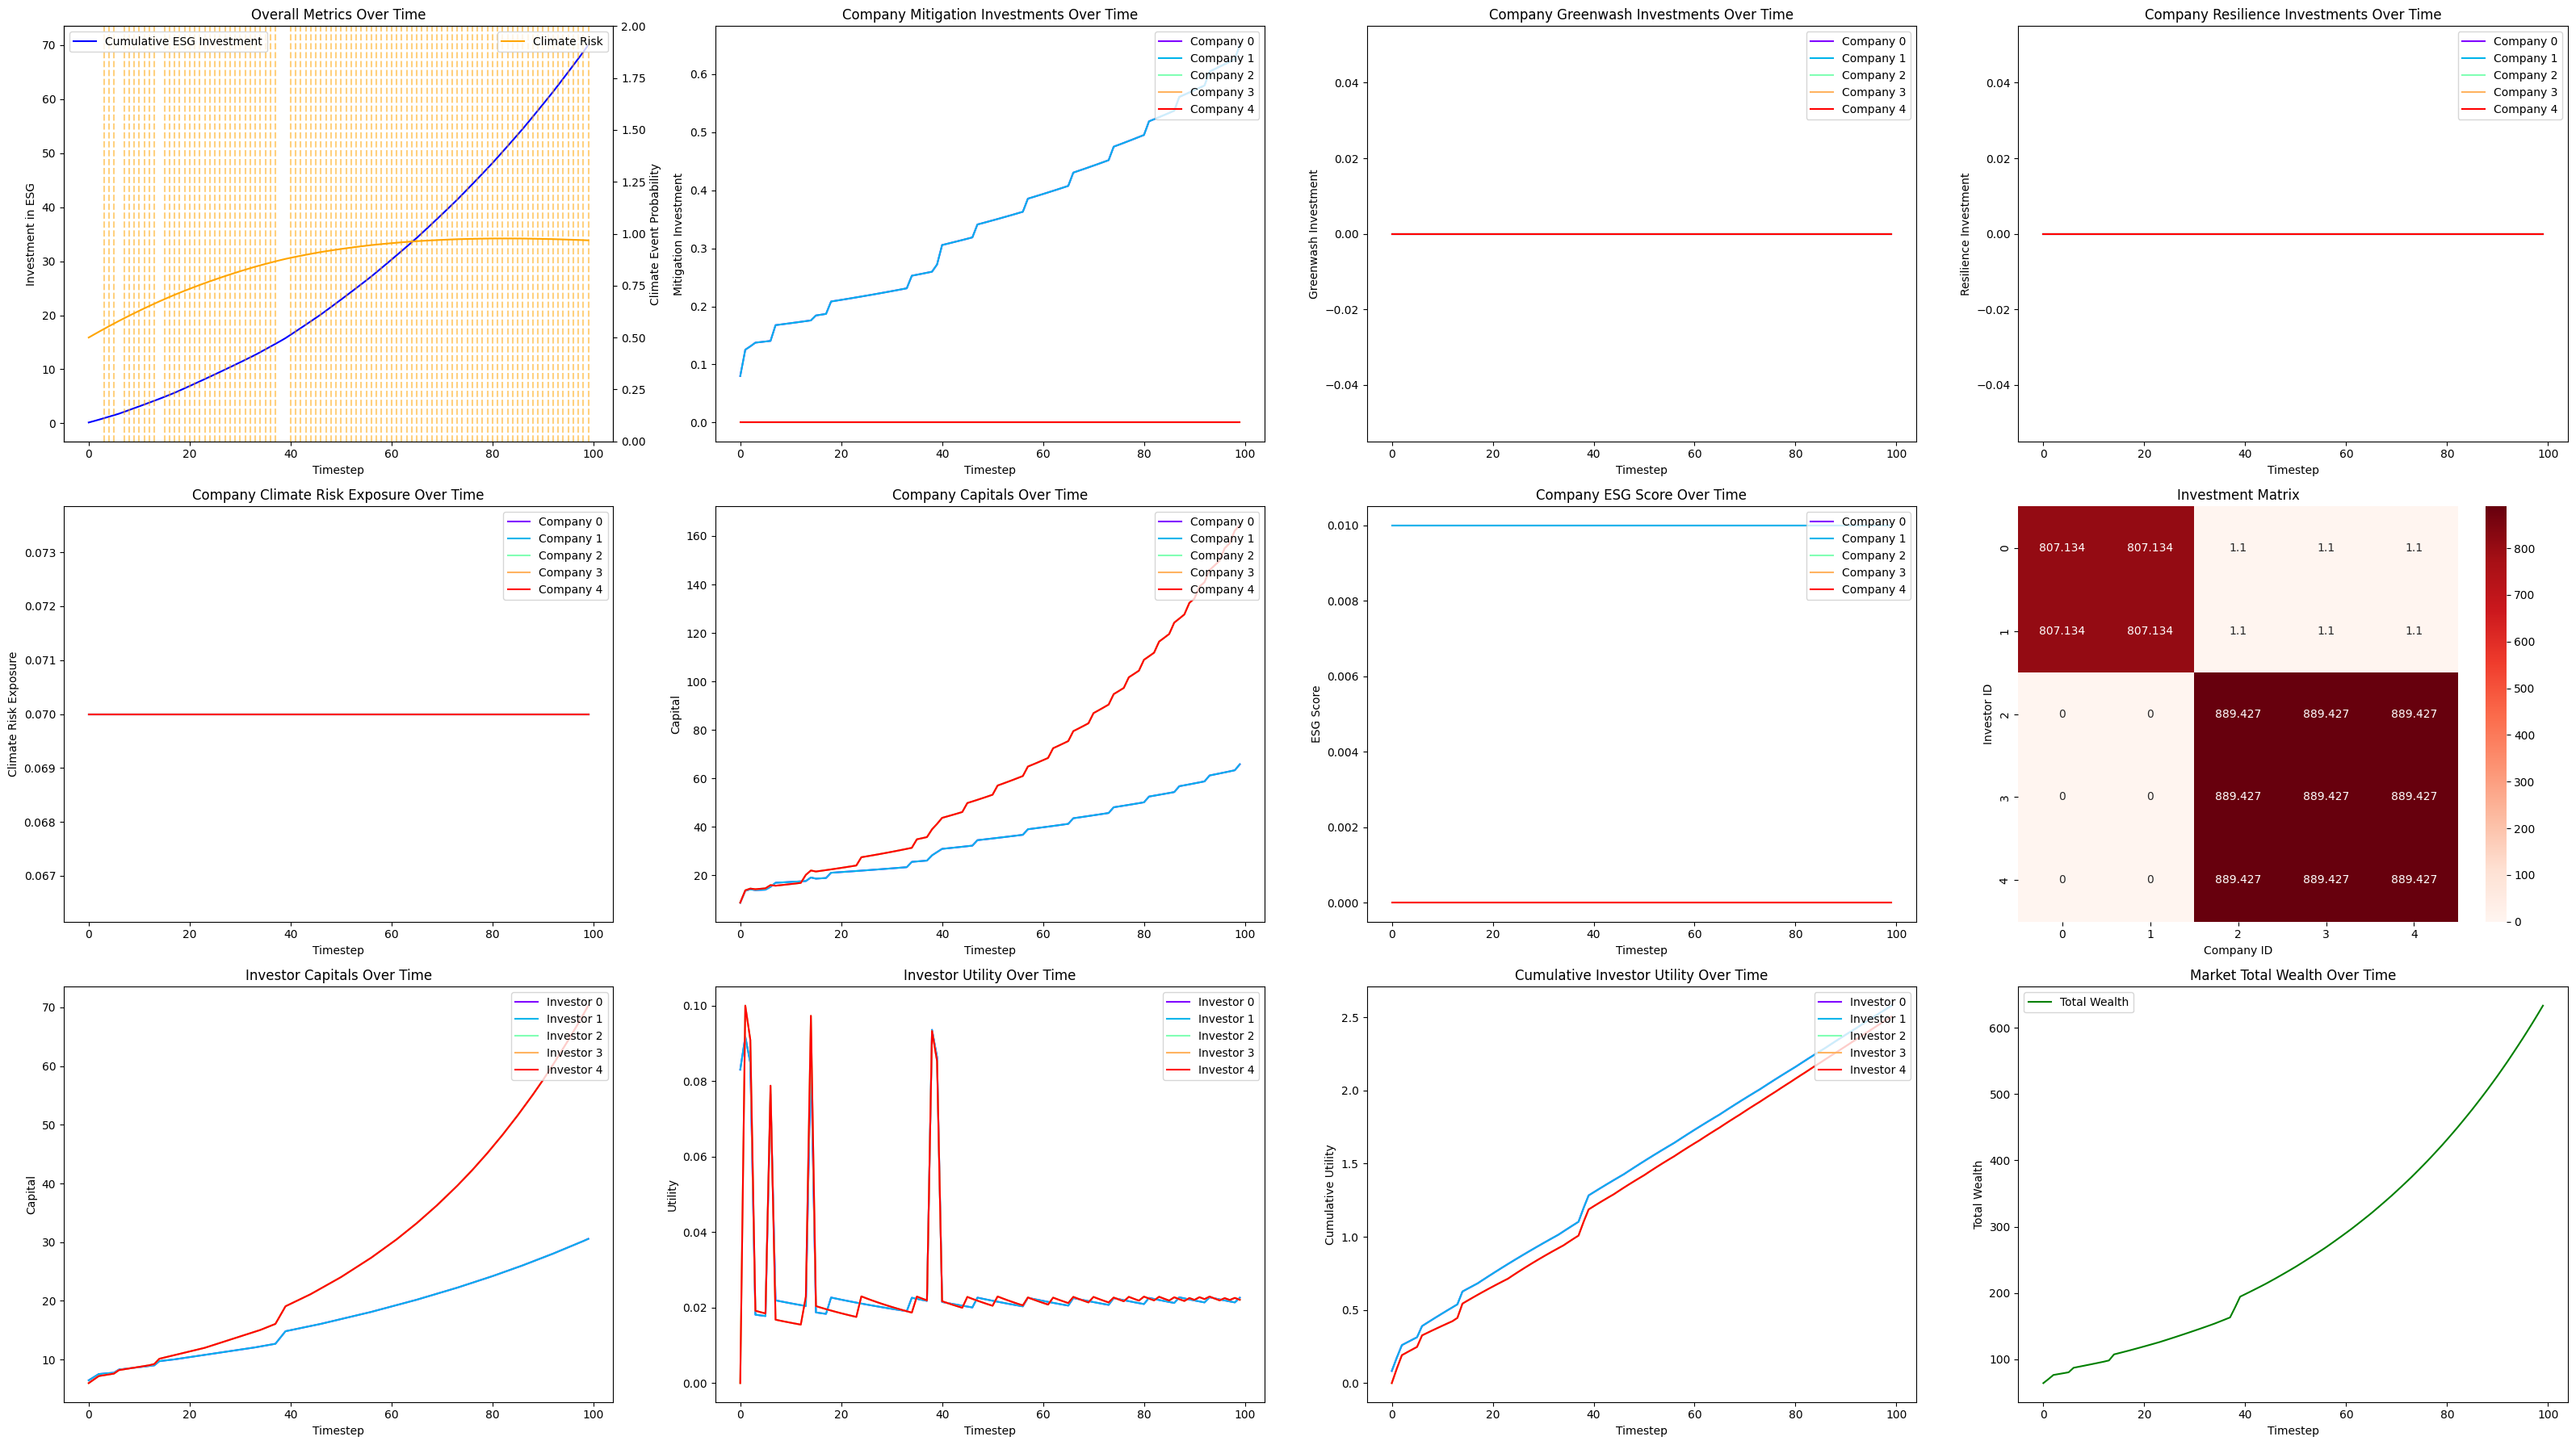

Company 0: 65.8524672877105
Company cooperator: 65.8524672877105
Company Defector: 164.42027689807887
Average company ending capital: 124.99315305393152


In [35]:
env = InvestESG(
    company_attributes=[{'capital': 6, 'climate_risk_exposure': 0.07, 'beta': 0}] * 5,
    investor_attributes=[{'capital': 6, 'esg_preference': 1}] * 2 + [{'capital': 6, 'esg_preference': 0}] * 3,
    initial_climate_event_probability=0.5,
    market_performance_baseline=1.1,
    market_performance_variance=0,
    allow_resilience_investment=True
)
manual_test_case([0.01,0,0],[0.01,0,0],[0,0,0], 1, output_fig=True)

<Figure size 640x480 with 0 Axes>

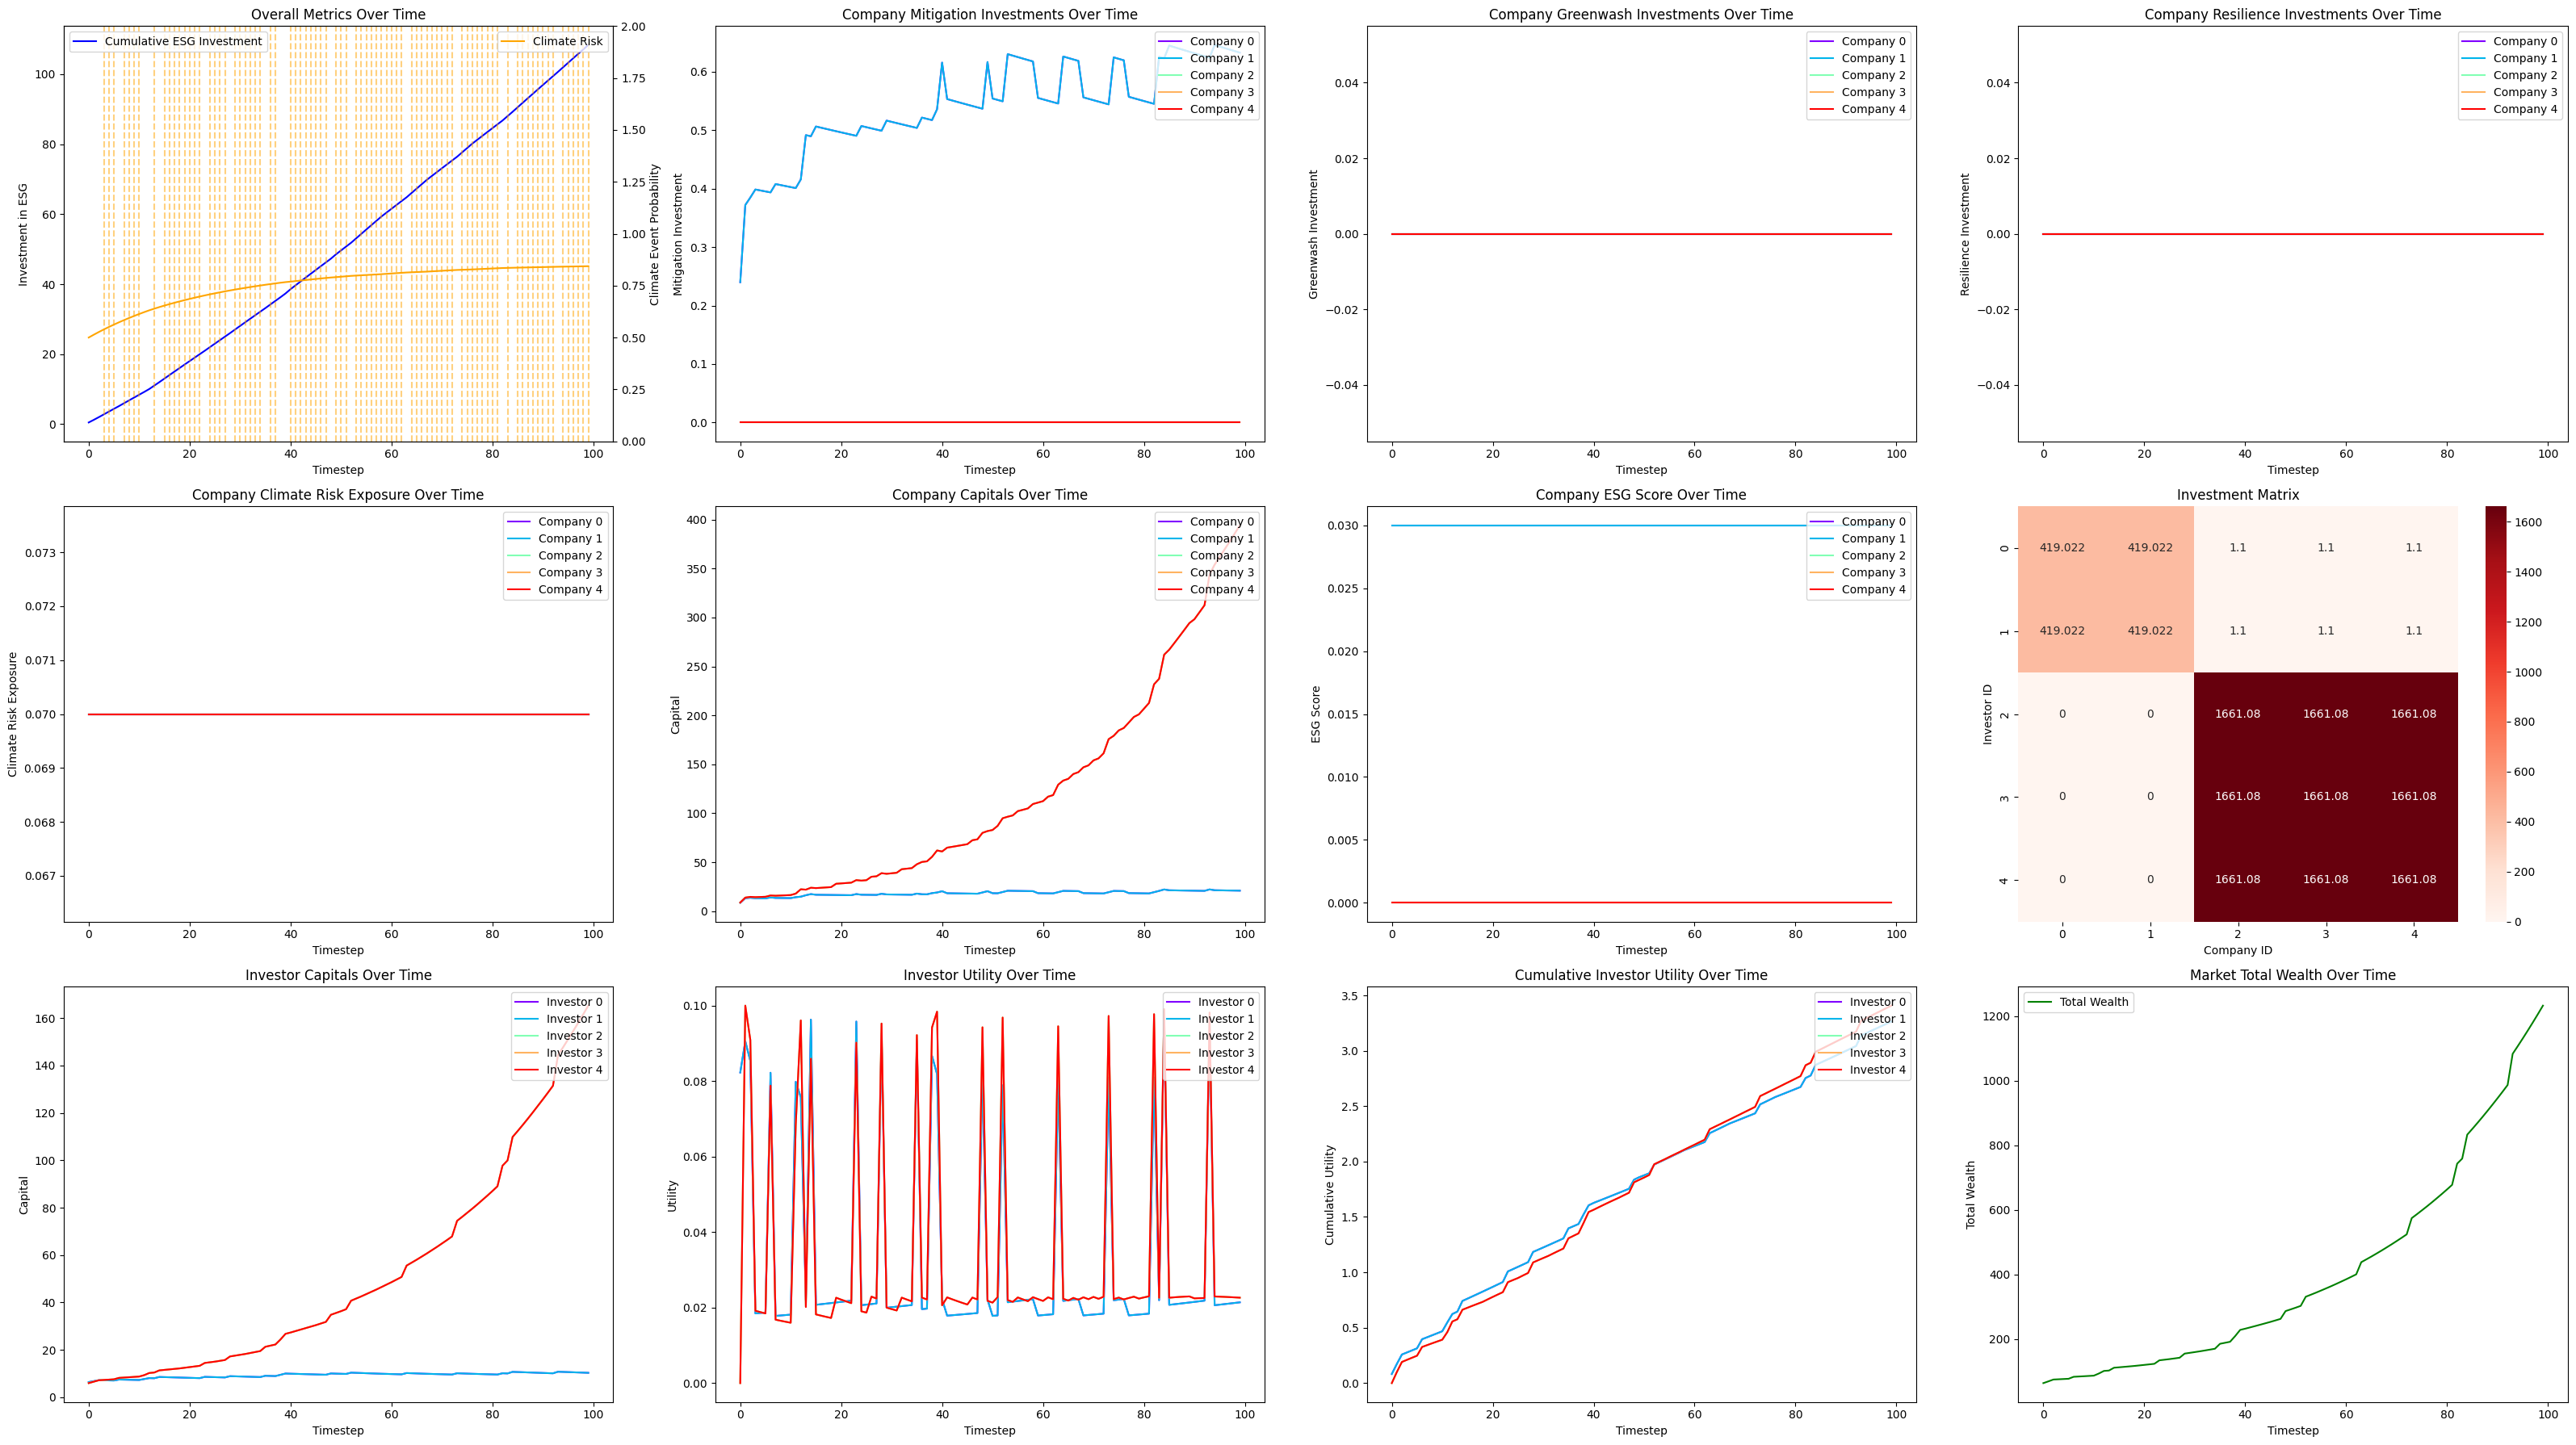

Company 0: 20.931191370929604
Company cooperator: 20.931191370929604
Company Defector: 394.15039227696815
Average company ending capital: 244.8627119145527


In [36]:
manual_test_case([0.03,0,0],[0.03,0,0],[0,0,0], 1, output_fig=True)

## Companies & Investors: Greenwash

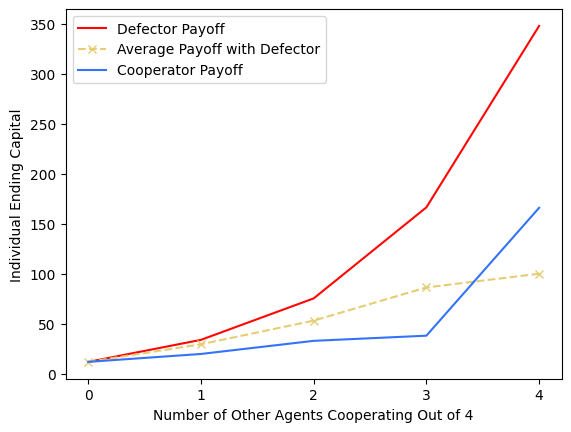

In [79]:
env = InvestESG(
    company_attributes=[{'capital': 6, 'climate_risk_exposure': 0.07, 'beta': 0, 'greenwash_esg_coef':10}] * 5,
    investor_attributes=[{'capital': 6, 'esg_preference': 5}] * 5,
    initial_climate_event_probability=0.5,
    market_performance_baseline=1.1,
    market_performance_variance=0,
    allow_resilience_investment=True,
    allow_greenwash_investment=True
)

cooperator_action = [0.01,0,0]
defector_action = [0,0.005,0]
run_schelling_diagram(cooperator_action, defector_action)

<Figure size 640x480 with 0 Axes>

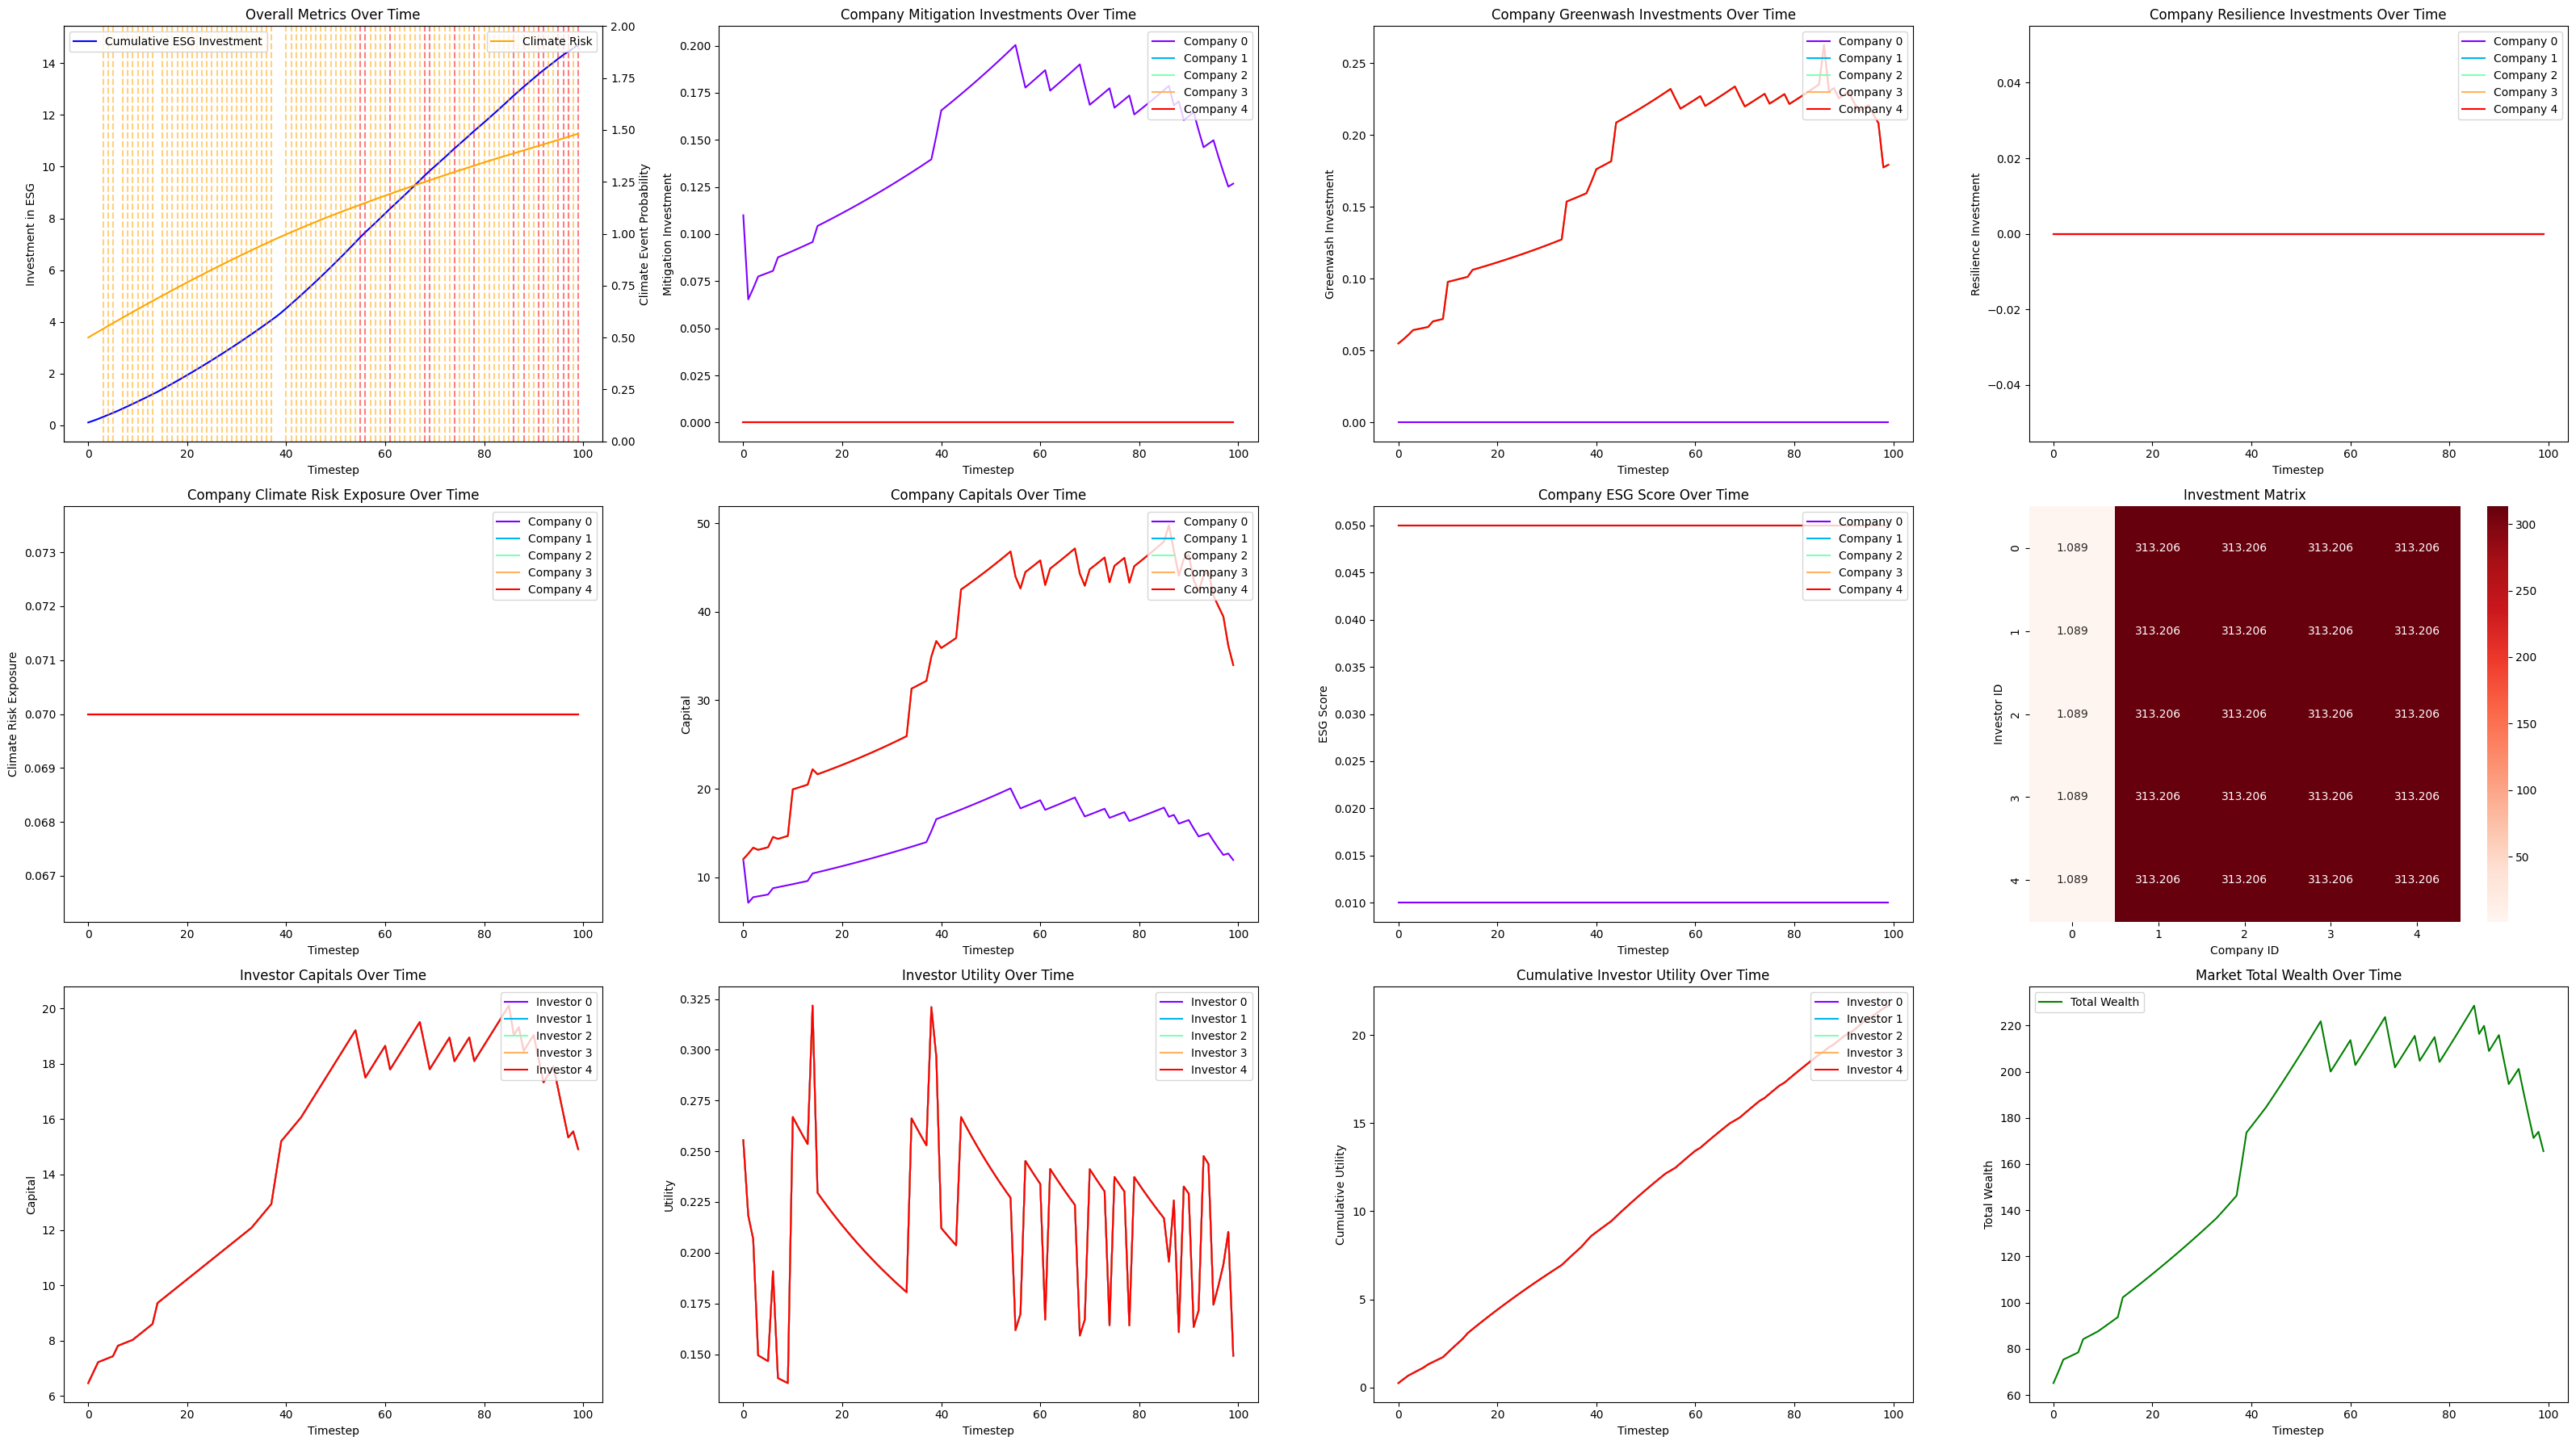

Company 0: 11.942566542197346
Company Defector: 33.964016343786405
Average company ending capital: 29.559726383468593


In [80]:
manual_test_case([0.01,0,0],[0.01,0,0],[0,0.005,0], 0, output_fig=True)

<Figure size 640x480 with 0 Axes>

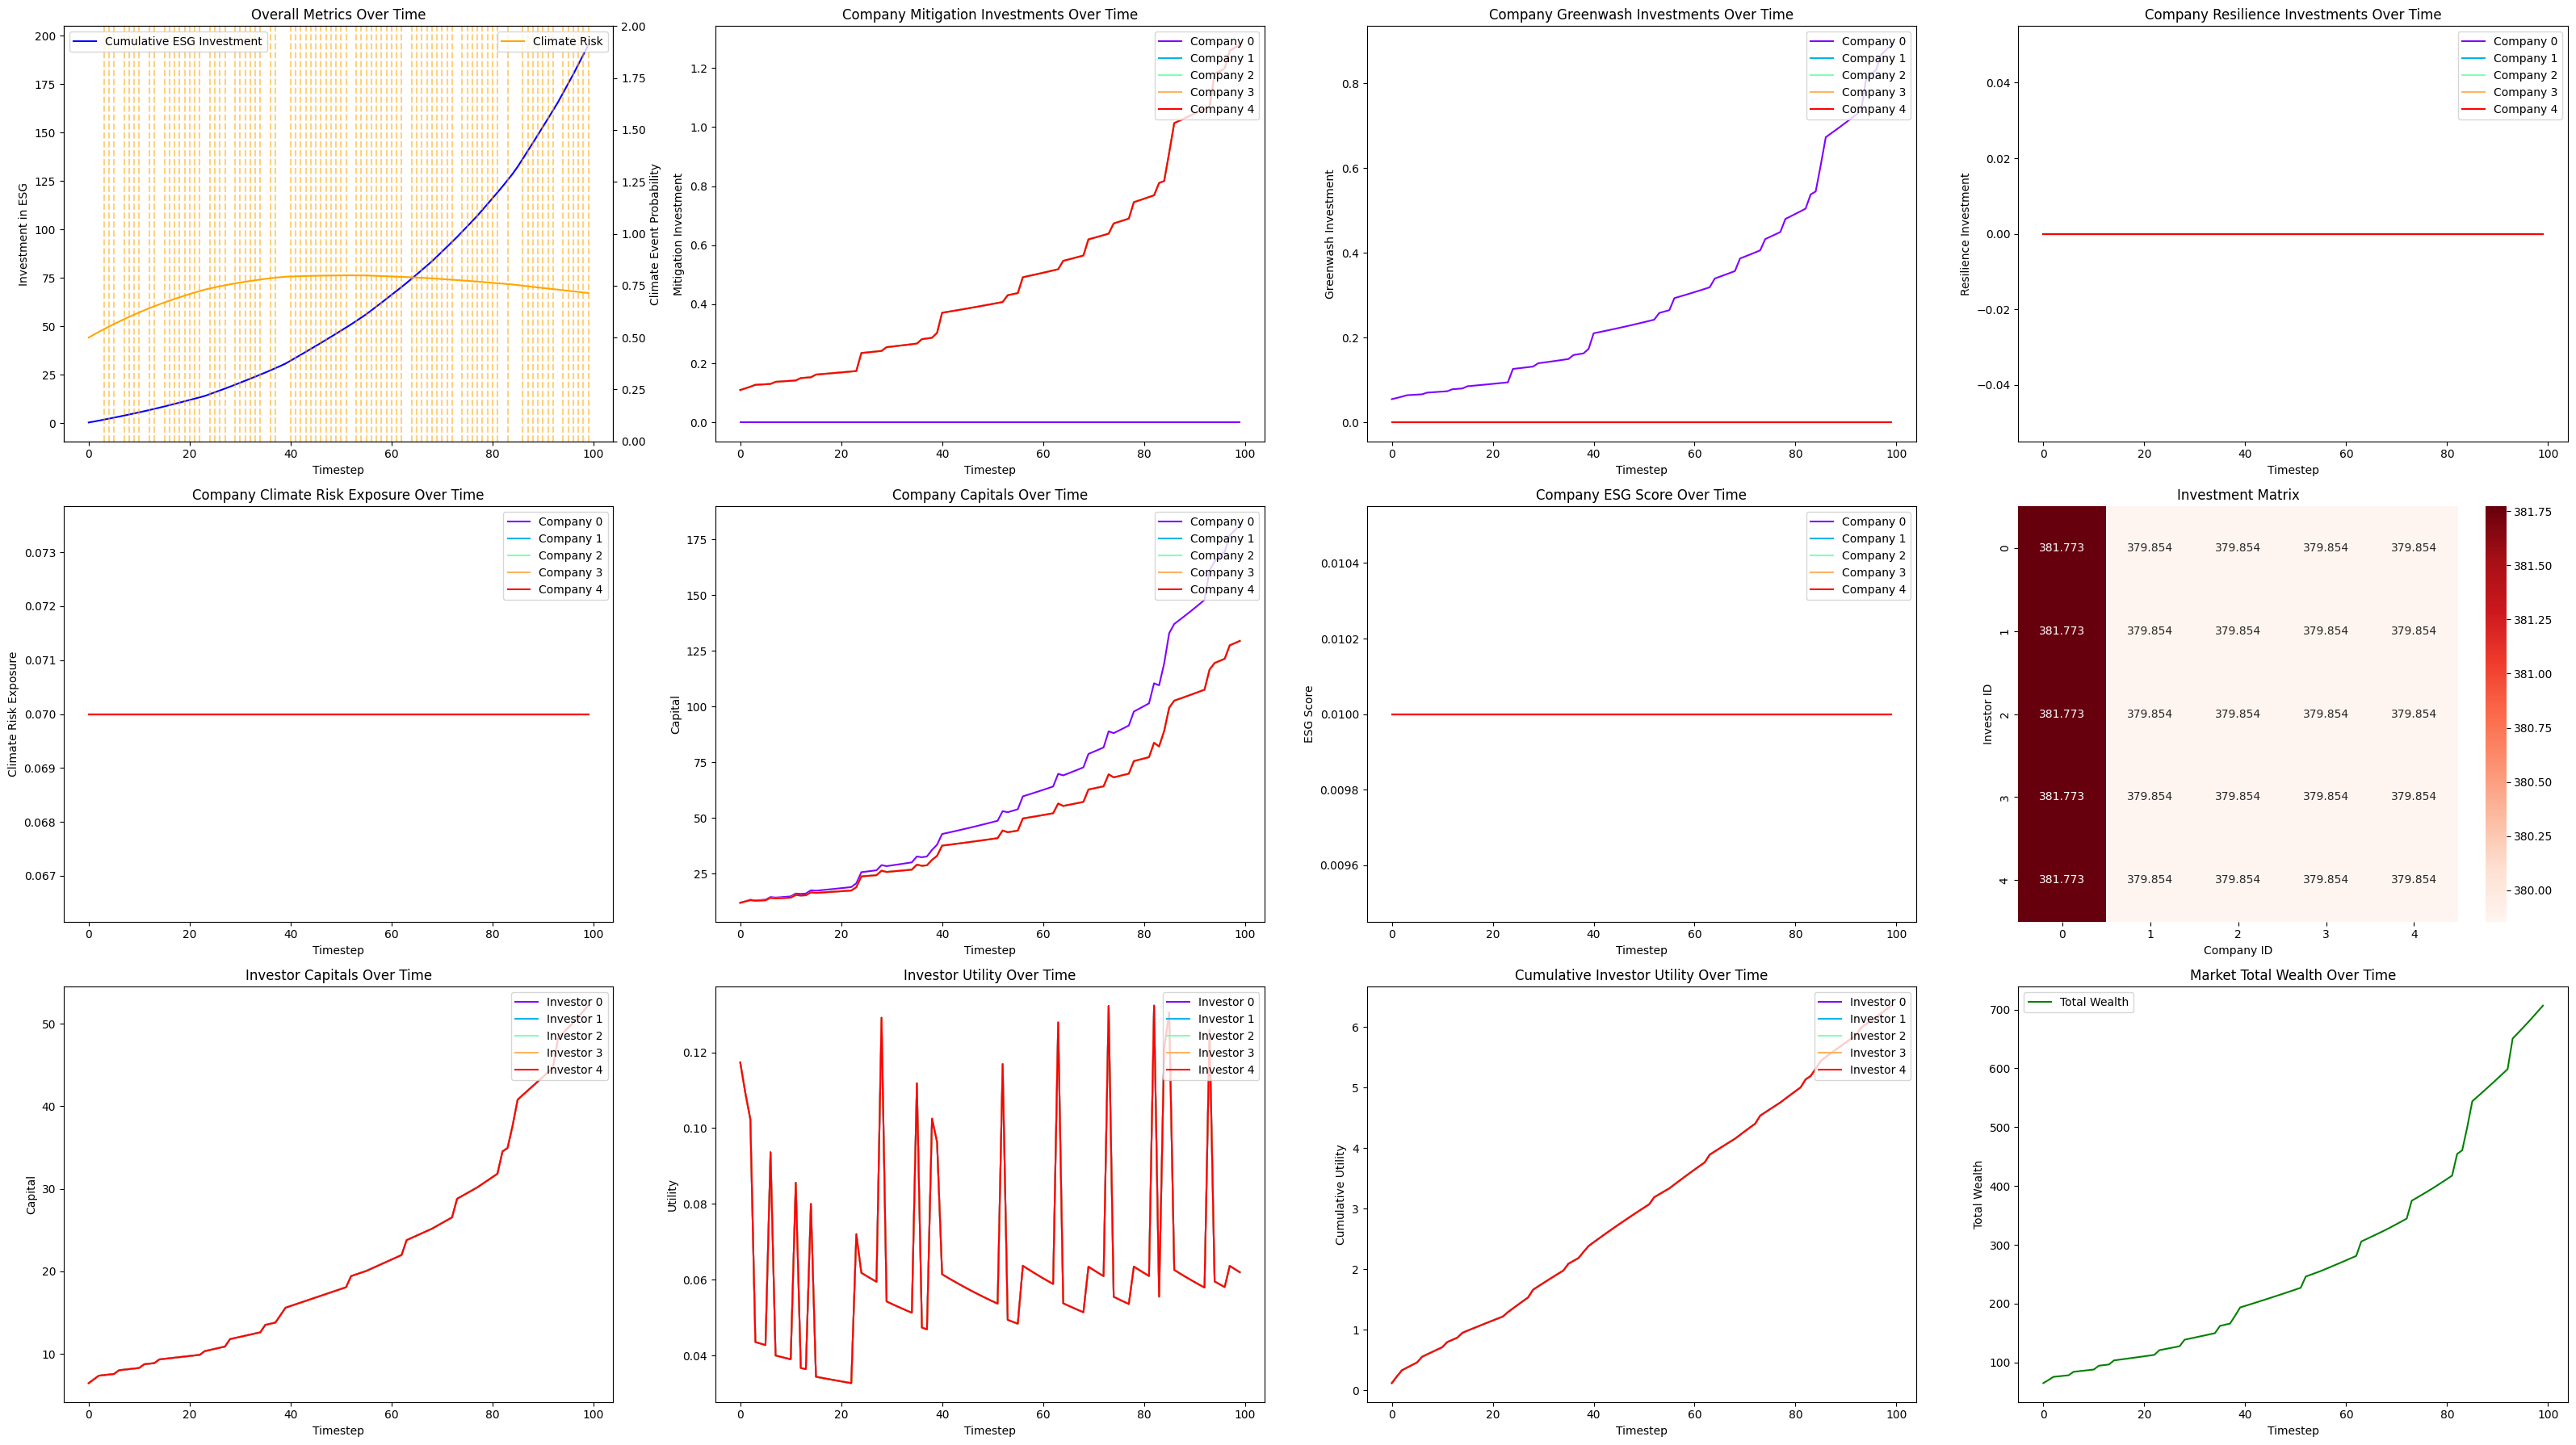

Company 0: 181.30987355443503
Company cooperator: 129.441183578911
Average company ending capital: 139.8149215740158


In [65]:
manual_test_case([0,0.005,0],[0.01,0,0],[0,0.005,0], 4, output_fig=True)